# 1 Configuration

## 1.1 Import Libraries

In [255]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib as matplot
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

print("Python ver: {}".format(sys.version))
print("Numpy ver: {}".format(np.__version__))
print("Pandas ver: {}".format(pd.__version__))
print("MatPlotLib ver: {}".format(matplot.__version__))
print("SeaBorn ver: {}".format(sns.__version__))
print("StatsModel ver: {}".format(sm.__version__))
print("Scipy ver: {}".format(scipy.__version__))
print("SkLearn ver: {}".format(sklearn.__version__))

Python ver: 3.9.1 (default, Jan 21 2021, 16:04:12) 
[Clang 12.0.0 (clang-1200.0.32.28)]
Numpy ver: 1.19.5
Pandas ver: 1.1.4
MatPlotLib ver: 3.3.3
SeaBorn ver: 0.11.1
StatsModel ver: 0.12.1
Scipy ver: 1.5.4
SkLearn ver: 0.24.1


In [256]:
def heatMap(df,max=1,min=-1):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(df, dtype=bool),1)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df, mask=mask, cmap=cmap, vmax=max, center=(max+min)/2, vmin=min,
                square=True, annot=True, linewidths=.2, cbar_kws={"shrink": .5})

    # Show the plot
    plt.show()
    
def checkCorrectness(df,originalLabel,predictedLabel):
    correct = len(df[(df[originalLabel] == df[predictedLabel])])
    incorrect = len(df) - correct
    return (correct,incorrect,(correct*100/(correct+incorrect)))

## 1.2 Pre configurations

In [257]:
import warnings

# Set Seaborn theme
sns.set_theme(color_codes=True)

# Disable warnings
warnings.simplefilter("ignore")

# 2 Data Preparation

## 2.1 Load the data

In [258]:
AimoScoreFileUrl = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/AimoScore_WeakLink_big_scores.xls"
WeakLinksFileUrl = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/20190108%20scores_and_weak_links.xlsx"

try:
    AimoScore = pd.read_excel(AimoScoreFileUrl, engine=None)
    WeakLinks = pd.read_excel(WeakLinksFileUrl, engine='openpyxl')

except IOError as e:
    print(e)


## 2.2 Merging the two datasets

### 2.2.1 Join the two tables via their ID

In [259]:
print("AimoScore size: {}".format(len(AimoScore)))
print("WeakLinks size: {}".format(len(WeakLinks)))
result = pd.merge(AimoScore, WeakLinks,on=["ID"])
print("result size: {}".format(len(result)))

AimoScore size: 2094
WeakLinks size: 2096
result size: 2094


### 2.2.2 Find the weakest link for each data point
Finding the column with the maximum score in each row and adding its name as a new column

In [260]:
result["WeakLinks"] = result.loc[:,"ForwardHead":"RightHeelRises"].idxmax(axis=1)

### 2.2.3 Discard extra columns
Discard the 14 weak link scores from the joint table

In [261]:
result.drop(result.columns.to_series()["ForwardHead":"RightHeelRises"], axis=1, inplace=True)

### 2.2.4 Remove Duplicates

In [262]:
result = result.drop_duplicates(subset="ID")

In [263]:
result["WeakLinks"].value_counts()

LeftArmFallForward              628
RightArmFallForward             472
RightKneeMovesOutward           276
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: WeakLinks, dtype: int64

### 2.2.5 Remove clusters with very few samples 

In [264]:
temp = (result["WeakLinks"].value_counts()<10)
temp = temp[~temp == False]
result = result[~result["WeakLinks"].isin(temp.index)]
result["WeakLinks"].value_counts()

LeftArmFallForward              628
RightArmFallForward             472
RightKneeMovesOutward           276
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
Name: WeakLinks, dtype: int64

In [265]:
result[["ID","SCORE","AimoScore","WeakLinks"]]

,ID,SCORE,AimoScore,WeakLinks
0,0003cdcc-86ed-494a-a3b5-90d09e96e06b.Kinect,0.323667,0.323667,RightShoulderElevation
1,003115c4-bdb8-491c-b571-8fcebdecf8ed.Kinect,0.323699,0.323699,RightArmFallForward
2,00316bfb-ed43-489f-a55b-11c7f01c852d.Kinect,0.848327,0.848327,LeftArmFallForward
3,00607608-6f2f-459b-a69d-e14067489459.Kinect,0.351332,0.351332,RightShoulderElevation
4,007396ec-3463-4a05-915c-02244ff8d3de.Kinect,0.627181,0.627181,ForwardHead
...,...,...,...,...
2086,feca4c0e-cbc7-4e5e-b85c-8befedbc65a4.Kinect,0.665494,0.665494,RightArmFallForward
2087,fed923af-f41e-42bc-8799-3a9f8a5f2129.Kinect,0.830883,0.830883,LeftArmFallForward
2088,ff015ddd-c9fb-49e3-8e33-abbf72e8b120.Kinect,0.527640,0.527640,LeftArmFallForward
2090,ff514cba-6c5e-41a9-9936-3e8400565c8d.Kinect,0.407197,0.407197,RightKneeMovesOutward


### Testing and Traing sets

In [266]:
from sklearn.model_selection import train_test_split

trainingPercent = 0.9

y_train,y_test ,X_train, X_test  = train_test_split(result[["WeakLinks"]], result.drop(columns=["WeakLinks","AimoScore","SCORE","ID","Date"]), train_size = trainingPercent)

### Logistic regression

In [267]:
from sklearn.linear_model import LogisticRegression

model_3 = LogisticRegression(solver='liblinear', C=25.0, random_state=0)
result_3 = model_3.fit(X_train, y_train)

print('Classes: ',result_3.classes_)
print('Intercept :', result_3.intercept_)
print('Coefficeients: ',result_3.coef_)

Classes:  ['ExcessiveForwardLean' 'ForwardHead' 'LeftArmFallForward'
 'LeftAsymmetricalWeightShift' 'LeftKneeMovesOutward'
 'LeftShoulderElevation' 'RightArmFallForward'
 'RightAsymmetricalWeightShift' 'RightKneeMovesInward'
 'RightKneeMovesOutward' 'RightShoulderElevation']
Intercept : [-13.48793456 -19.28291147  -7.42058976  -6.92998499  -2.62620683
  -4.3295402   -3.25085049  -7.67485128   2.80284828   0.50808045
   3.44668994]
Coefficeients:  [[-4.73803955e-01  1.15880597e+00 -3.60542669e+00  1.88535702e+00
  -1.00799049e+00 -3.21382782e-01 -3.19291735e-01  3.24880082e+00
  -1.36841764e+00  1.34228313e+00 -1.47206124e+00  5.47210817e-01
  -3.35950338e-01 -1.00799049e+00 -3.19291735e-01 -4.73803955e-01
   1.34228313e+00 -3.35950338e-01 -3.13117117e+00  2.36761078e-01
  -3.81416237e-02 -1.66592371e+00  1.91698286e+01 -2.36606023e+00
   3.95023478e-01  1.25774306e+00  1.52058632e-01  4.28407387e-01
  -3.67796211e-01  1.35022587e+00 -1.64782509e+00 -2.47638712e+00
   2.25595211e+00  2.

In [268]:
prob = result_3.predict_proba(X_test)

# Find maximum value from probability prediction array
maxValues = pd.DataFrame(prob, columns = range(0,11))

# Dominant WeakLink
dominant = result_3.classes_[maxValues.idxmax(axis=1, skipna=True)]

comparison = pd.DataFrame({'Original': y_test.WeakLinks, 'Dominant':dominant})
comparison

,Original,Dominant
528,RightShoulderElevation,RightShoulderElevation
152,RightKneeMovesOutward,RightKneeMovesOutward
1916,LeftAsymmetricalWeightShift,LeftArmFallForward
1428,LeftArmFallForward,RightShoulderElevation
825,RightKneeMovesOutward,RightKneeMovesOutward
...,...,...
29,LeftArmFallForward,LeftArmFallForward
80,RightAsymmetricalWeightShift,LeftArmFallForward
1710,RightArmFallForward,RightArmFallForward
1496,RightArmFallForward,RightArmFallForward


In [269]:
c,e,p = checkCorrectness(comparison,"Original","Dominant")

print("correct:" + str(c))
print("incorrect:" + str(e))
print("percentage:" + str(p))

correct:138
incorrect:71
percentage:66.02870813397129


In [ ]:
# Save champion model
import joblib

joblib.dump(result_3, "logistic_regression.joblib")

In [270]:
confusion_matrix = comparison.groupby(['Dominant','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Dominant,,,,,,,,,,,
ExcessiveForwardLean,4.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
ForwardHead,2.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
LeftArmFallForward,2.0,0.0,48.0,2.0,0.0,2.0,14.0,1.0,3.0,0.0,2.0
LeftAsymmetricalWeightShift,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LeftKneeMovesOutward,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
LeftShoulderElevation,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
RightArmFallForward,0.0,3.0,9.0,0.0,1.0,0.0,20.0,0.0,0.0,1.0,5.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
RightKneeMovesInward,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


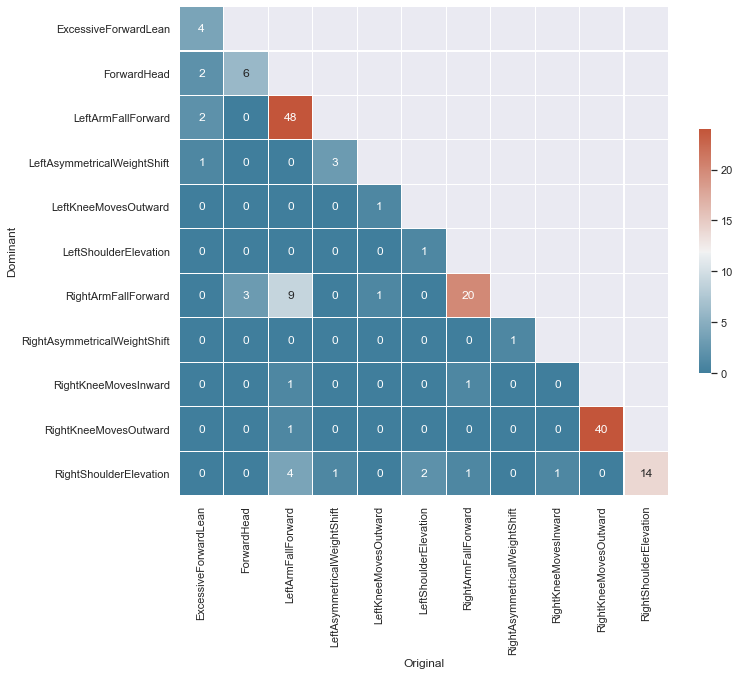

In [271]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### LDA (Linear Discriminant Analysis)

In [272]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_4 = LinearDiscriminantAnalysis()
result_4 = model_4.fit(X_train, y_train)

print(result_4.classes_)
print(result_4.priors_)
print(result_4.means_)
print(result_4.coef_)

['ExcessiveForwardLean' 'ForwardHead' 'LeftArmFallForward'
 'LeftAsymmetricalWeightShift' 'LeftKneeMovesOutward'
 'LeftShoulderElevation' 'RightArmFallForward'
 'RightAsymmetricalWeightShift' 'RightKneeMovesInward'
 'RightKneeMovesOutward' 'RightShoulderElevation']
[0.04850746 0.0554371  0.30063966 0.03411514 0.0250533  0.02771855
 0.23240938 0.00906183 0.02185501 0.12526652 0.11993603]
[[0.69861415 0.76791167 0.51206374 0.67298364 0.4071715  0.65410104
  0.38467845 0.82754978 0.43899286 0.58361581 0.76957762 0.4616751
  0.59255522 0.4071715  0.38467845 0.69861415 0.58361581 0.59255522
  0.6232204  0.58942301 0.7465748  0.72212675 0.93823345 0.55054367
  0.53481956 0.69960742 0.48999112 0.57224841 0.48281226 0.70546192
  0.65721748 0.75057415 0.72153289 0.74697421 0.6769462  0.69894524
  0.64024259 0.54641819 0.5046116  0.52474498 0.58075163]
 [0.67017069 0.67576243 0.7162151  0.57936946 0.53023029 0.51204797
  0.55072564 0.71653699 0.43668377 0.40798937 0.72093312 0.36465806
  0.42019

In [273]:
y_pred=model_4.predict(X_test)

In [274]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,
                        'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,5.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0
ForwardHead,2.0,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
LeftArmFallForward,0.0,1.0,45.0,0.0,0.0,1.0,11.0,0.0,3.0,0.0,2.0
LeftAsymmetricalWeightShift,2.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
LeftKneeMovesOutward,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0
LeftShoulderElevation,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
RightArmFallForward,0.0,1.0,12.0,0.0,1.0,0.0,20.0,0.0,0.0,0.0,3.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
RightKneeMovesInward,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


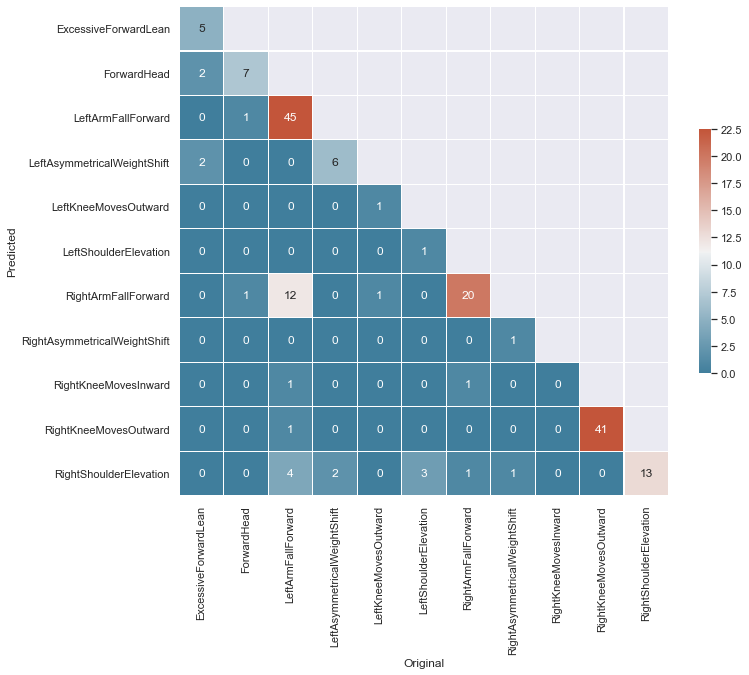

In [275]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

In [276]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[ 5  2  1  0  0  1  1  0  0  0  2]
 [ 2  7  0  1  0  0  1  0  0  0  1]
 [ 0  1 45  0  0  1 11  0  3  0  2]
 [ 2  0  0  6  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  1  0  3]
 [ 0  0  0  0  0  1  0  0  0  0  0]
 [ 0  1 12  0  1  0 20  0  0  0  3]
 [ 0  0  0  0  0  0  0  1  0  0  1]
 [ 0  0  1  0  0  0  1  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0 41  0]
 [ 0  0  4  2  0  3  1  1  0  0 13]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.417     0.556     0.476         9
                 ForwardHead      0.583     0.636     0.609        11
          LeftArmFallForward      0.714     0.703     0.709        64
 LeftAsymmetricalWeightShift      0.667     0.667     0.667         9
        LeftKneeMovesOutward      0.200     0.500     0.286         2
       LeftShoulderElevation      1.000     0.167     0.286         6
         RightArmFallForward      0.541     0.556     0.548        36
RightAsymmetricalWeightShift      0.500   

### QDA

In [277]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model_5 = QuadraticDiscriminantAnalysis()
result_5 = model_5.fit(X_train, y_train)

print(result_5.priors_)
print(result_5.means_)

[0.04850746 0.0554371  0.30063966 0.03411514 0.0250533  0.02771855
 0.23240938 0.00906183 0.02185501 0.12526652 0.11993603]
[[0.69861415 0.76791167 0.51206374 0.67298364 0.4071715  0.65410104
  0.38467845 0.82754978 0.43899286 0.58361581 0.76957762 0.4616751
  0.59255522 0.4071715  0.38467845 0.69861415 0.58361581 0.59255522
  0.6232204  0.58942301 0.7465748  0.72212675 0.93823345 0.55054367
  0.53481956 0.69960742 0.48999112 0.57224841 0.48281226 0.70546192
  0.65721748 0.75057415 0.72153289 0.74697421 0.6769462  0.69894524
  0.64024259 0.54641819 0.5046116  0.52474498 0.58075163]
 [0.67017069 0.67576243 0.7162151  0.57936946 0.53023029 0.51204797
  0.55072564 0.71653699 0.43668377 0.40798937 0.72093312 0.36465806
  0.42019369 0.53023029 0.55072564 0.67017069 0.40798937 0.42019369
  0.55814756 0.93963139 0.55624839 0.54042968 0.59976364 0.52426149
  0.52920483 0.62803039 0.41134625 0.63255527 0.43500074 0.75922911
  0.57537799 0.7586773  0.69042232 0.69164551 0.63236674 0.70968528
  0

In [278]:
y_pred=model_5.predict(X_test)

In [279]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[ 1  0  1  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 4  5 37  4  1  3 20  0  3  2 10]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  0  0  0  0  0]
 [ 0  4 21  0  0  0 13  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 34  0]
 [ 4  1  4  3  1  3  3  2  0  3 12]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.500     0.111     0.182         9
                 ForwardHead      1.000     0.091     0.167        11
          LeftArmFallForward      0.416     0.578     0.484        64
 LeftAsymmetricalWeightShift      1.000     0.111     0.200         9
        LeftKneeMovesOutward      0.000     0.000     0.000         2
       LeftShoulderElevation      0.000     0.000     0.000         6
         RightArmFallForward      0.295     0.361     0.325        36
RightAsymmetricalWeightShift      0.000   

In [280]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ForwardHead,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LeftArmFallForward,4.0,5.0,37.0,4.0,1.0,3.0,20.0,0.0,3.0,2.0,10.0
LeftAsymmetricalWeightShift,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LeftShoulderElevation,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RightArmFallForward,0.0,4.0,21.0,0.0,0.0,0.0,13.0,0.0,1.0,2.0,3.0
RightKneeMovesOutward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0
RightShoulderElevation,4.0,1.0,4.0,3.0,1.0,3.0,3.0,2.0,0.0,3.0,12.0


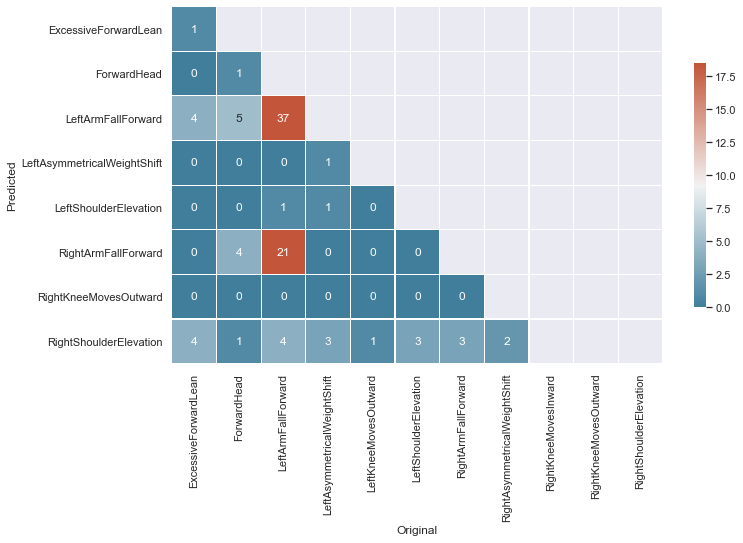

In [281]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### K-Nearest Neighbors Clustering K=1

In [282]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_6 = neighbors.KNeighborsClassifier(n_neighbors=1)
result_6 = model_6.fit(X_train, y_train)
y_pred = result_6.predict(X_test)

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[ 6  1  2  0  0  0  1  0  0  0  4]
 [ 2  6  0  2  0  0  2  0  0  0  0]
 [ 0  1 30  2  0  3 11  0  1  1  3]
 [ 0  1  0  1  0  0  0  0  0  0  0]
 [ 1  0  1  0  1  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2 21  1  1  1 19  0  1  0  2]
 [ 0  0  0  1  0  0  0  1  0  0  0]
 [ 0  0  1  1  0  1  1  0  1  0  1]
 [ 0  0  2  0  0  0  0  0  0 40  0]
 [ 0  0  7  1  0  1  1  1  1  0 15]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.429     0.667     0.522         9
                 ForwardHead      0.500     0.545     0.522        11
          LeftArmFallForward      0.577     0.469     0.517        64
 LeftAsymmetricalWeightShift      0.500     0.111     0.182         9
        LeftKneeMovesOutward      0.250     0.500     0.333         2
       LeftShoulderElevation      0.000     0.000     0.000         6
         RightArmFallForward      0.396     0.528     0.452        36
RightAsymmetricalWeightShift      0.500   

In [283]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,6.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0
ForwardHead,2.0,6.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
LeftArmFallForward,0.0,1.0,30.0,2.0,0.0,3.0,11.0,0.0,1.0,1.0,3.0
LeftAsymmetricalWeightShift,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LeftKneeMovesOutward,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
RightArmFallForward,0.0,2.0,21.0,1.0,1.0,1.0,19.0,0.0,1.0,0.0,2.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
RightKneeMovesInward,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
RightKneeMovesOutward,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0


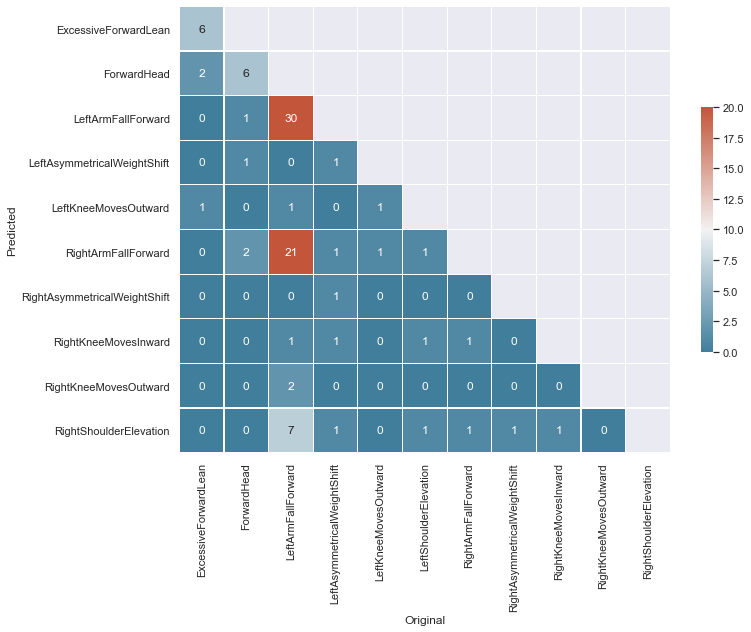

In [284]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### K-Nearest Neighbors Clustering K=2

In [285]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_7 = neighbors.KNeighborsClassifier(n_neighbors=2)
result_7 = model_7.fit(X_train, y_train)
y_pred = result_7.predict(X_test)

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[ 7  2  4  1  0  0  3  0  0  0  4]
 [ 2  6  2  2  0  0  3  0  0  0  1]
 [ 0  1 40  4  0  3 16  0  2  1  5]
 [ 0  1  0  1  0  0  0  0  0  0  2]
 [ 0  0  1  0  2  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  1]
 [ 0  1 12  0  0  1 13  0  1  0  3]
 [ 0  0  0  0  0  1  0  1  0  0  0]
 [ 0  0  0  1  0  0  0  0  1  0  2]
 [ 0  0  2  0  0  0  0  0  0 40  0]
 [ 0  0  3  0  0  0  0  1  0  0  7]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.333     0.778     0.467         9
                 ForwardHead      0.375     0.545     0.444        11
          LeftArmFallForward      0.556     0.625     0.588        64
 LeftAsymmetricalWeightShift      0.250     0.111     0.154         9
        LeftKneeMovesOutward      0.500     1.000     0.667         2
       LeftShoulderElevation      0.500     0.167     0.250         6
         RightArmFallForward      0.419     0.361     0.388        36
RightAsymmetricalWeightShift      0.500   

In [286]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,7.0,2.0,4.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0
ForwardHead,2.0,6.0,2.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
LeftArmFallForward,0.0,1.0,40.0,4.0,0.0,3.0,16.0,0.0,2.0,1.0,5.0
LeftAsymmetricalWeightShift,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
LeftKneeMovesOutward,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
LeftShoulderElevation,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
RightArmFallForward,0.0,1.0,12.0,0.0,0.0,1.0,13.0,0.0,1.0,0.0,3.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
RightKneeMovesInward,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0


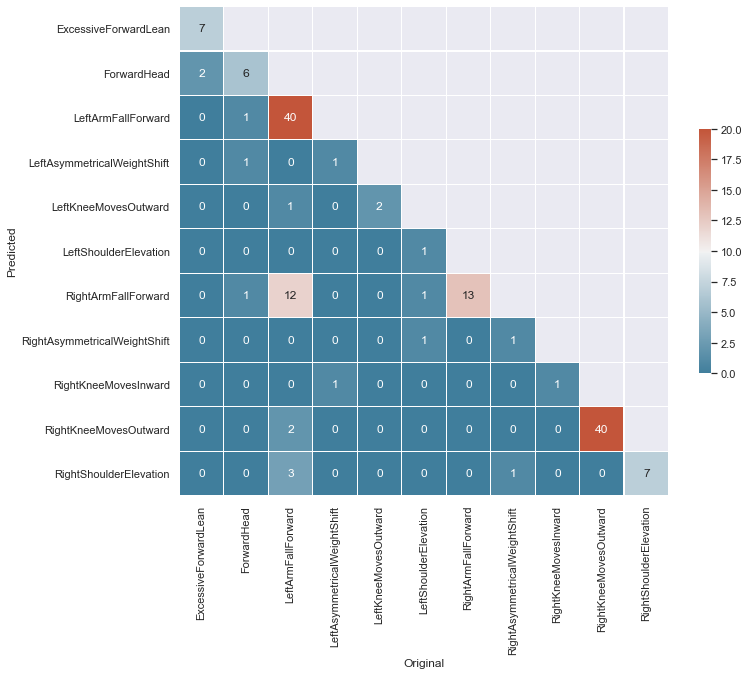

In [287]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### K-Nearest Neighbors Clustering K=3

In [288]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_7 = neighbors.KNeighborsClassifier(n_neighbors=3)
result_7 = model_7.fit(X_train, y_train)
y_pred = result_7.predict(X_test)

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[ 7  2  4  1  0  1  2  0  0  0  4]
 [ 2  7  3  2  0  0  3  0  0  0  1]
 [ 0  0 32  3  0  2 12  0  2  0  5]
 [ 0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  2  0  2  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  1]
 [ 0  2 17  0  0  1 17  0  1  0  4]
 [ 0  0  0  0  0  1  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0 41  0]
 [ 0  0  5  1  0  0  1  1  1  0 10]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.333     0.778     0.467         9
                 ForwardHead      0.389     0.636     0.483        11
          LeftArmFallForward      0.571     0.500     0.533        64
 LeftAsymmetricalWeightShift      1.000     0.222     0.364         9
        LeftKneeMovesOutward      0.400     1.000     0.571         2
       LeftShoulderElevation      0.500     0.167     0.250         6
         RightArmFallForward      0.405     0.472     0.436        36
RightAsymmetricalWeightShift      0.500   

In [289]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,7.0,2.0,4.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,4.0
ForwardHead,2.0,7.0,3.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
LeftArmFallForward,0.0,0.0,32.0,3.0,0.0,2.0,12.0,0.0,2.0,0.0,5.0
LeftAsymmetricalWeightShift,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LeftKneeMovesOutward,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
LeftShoulderElevation,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
RightArmFallForward,0.0,2.0,17.0,0.0,0.0,1.0,17.0,0.0,1.0,0.0,4.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
RightKneeMovesOutward,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0


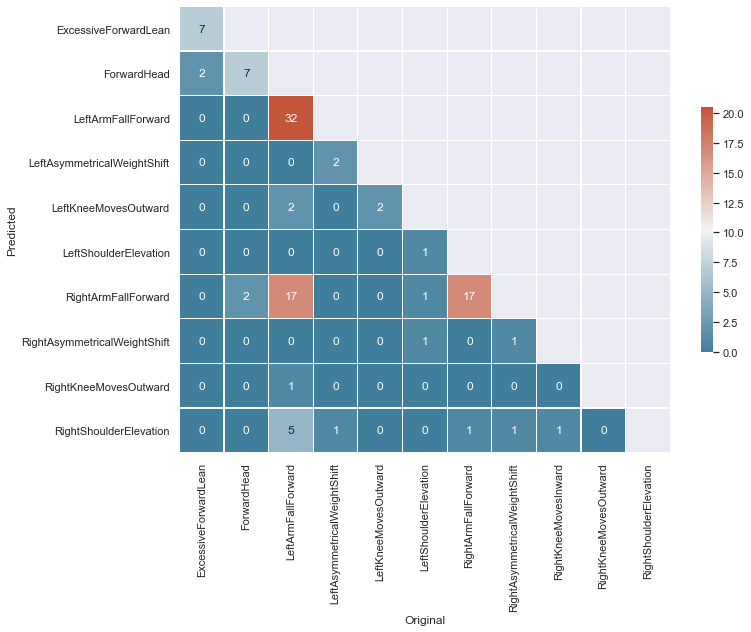

In [290]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### K-Nearest Neighbors Clustering K=4

In [291]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_7 = neighbors.KNeighborsClassifier(n_neighbors=4)
result_7 = model_7.fit(X_train, y_train)
y_pred = result_7.predict(X_test)

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[ 6  1  2  1  0  1  1  0  0  0  4]
 [ 3  6  1  2  0  0  1  0  0  0  1]
 [ 0  0 38  2  0  2 14  1  2  0  2]
 [ 0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  2  0  2  0  1  0  0  0  1]
 [ 0  0  0  0  0  1  0  0  0  0  1]
 [ 0  4 16  0  0  1 18  0  1  0  5]
 [ 0  0  0  0  0  1  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 41  0]
 [ 0  0  5  2  0  0  1  0  1  0 11]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.375     0.667     0.480         9
                 ForwardHead      0.429     0.545     0.480        11
          LeftArmFallForward      0.623     0.594     0.608        64
 LeftAsymmetricalWeightShift      1.000     0.222     0.364         9
        LeftKneeMovesOutward      0.333     1.000     0.500         2
       LeftShoulderElevation      0.500     0.167     0.250         6
         RightArmFallForward      0.400     0.500     0.444        36
RightAsymmetricalWeightShift      0.500   

In [292]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,6.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0
ForwardHead,3.0,6.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
LeftArmFallForward,0.0,0.0,38.0,2.0,0.0,2.0,14.0,1.0,2.0,0.0,2.0
LeftAsymmetricalWeightShift,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LeftKneeMovesOutward,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0
LeftShoulderElevation,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
RightArmFallForward,0.0,4.0,16.0,0.0,0.0,1.0,18.0,0.0,1.0,0.0,5.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
RightKneeMovesOutward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0


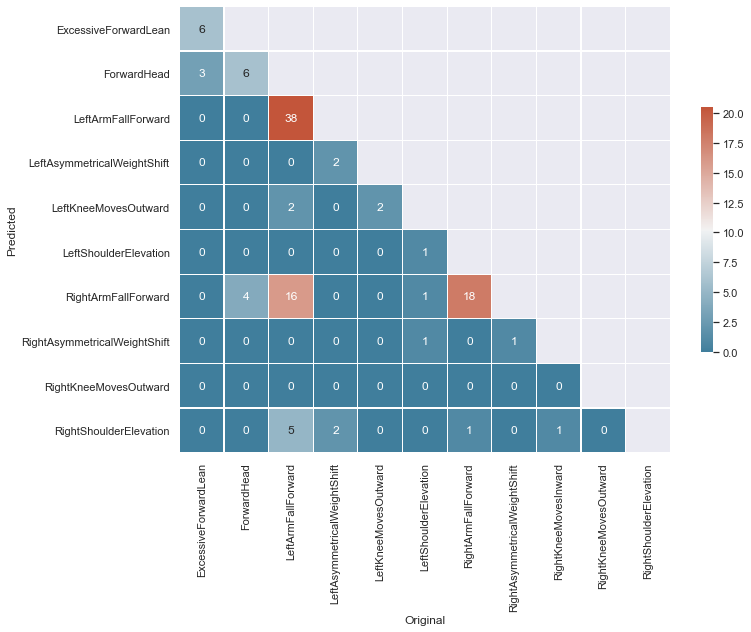

In [293]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)

### K-Nearest Neighbors Clustering K=5

In [294]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_7 = neighbors.KNeighborsClassifier(n_neighbors=5)
result_7 = model_7.fit(X_train, y_train)
y_pred = result_7.predict(X_test)

print(confusion_matrix(y_test, y_pred).T)
print(classification_report(y_test, y_pred, digits=3))

[[ 6  1  2  0  0  1  2  0  0  0  4]
 [ 3  7  0  2  0  1  0  0  0  0  1]
 [ 0  0 34  2  0  2 14  1  1  0  4]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  2  0  2  0  1  0  0  0  1]
 [ 0  0  0  0  0  1  0  0  0  0  1]
 [ 0  3 22  0  0  0 18  0  1  0  4]
 [ 0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  1 41  0]
 [ 0  0  4  4  0  1  1  0  0  0 10]]
                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.375     0.667     0.480         9
                 ForwardHead      0.500     0.636     0.560        11
          LeftArmFallForward      0.586     0.531     0.557        64
 LeftAsymmetricalWeightShift      1.000     0.111     0.200         9
        LeftKneeMovesOutward      0.333     1.000     0.500         2
       LeftShoulderElevation      0.500     0.167     0.250         6
         RightArmFallForward      0.375     0.500     0.429        36
RightAsymmetricalWeightShift      1.000   

In [295]:
comparison = pd.DataFrame({'Original': y_test.WeakLinks,'Predicted': y_pred})

confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)
confusion_matrix

Original,ExcessiveForwardLean,ForwardHead,LeftArmFallForward,LeftAsymmetricalWeightShift,LeftKneeMovesOutward,LeftShoulderElevation,RightArmFallForward,RightAsymmetricalWeightShift,RightKneeMovesInward,RightKneeMovesOutward,RightShoulderElevation
Predicted,,,,,,,,,,,
ExcessiveForwardLean,6.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,4.0
ForwardHead,3.0,7.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
LeftArmFallForward,0.0,0.0,34.0,2.0,0.0,2.0,14.0,1.0,1.0,0.0,4.0
LeftAsymmetricalWeightShift,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LeftKneeMovesOutward,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0
LeftShoulderElevation,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
RightArmFallForward,0.0,3.0,22.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,4.0
RightAsymmetricalWeightShift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
RightKneeMovesInward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


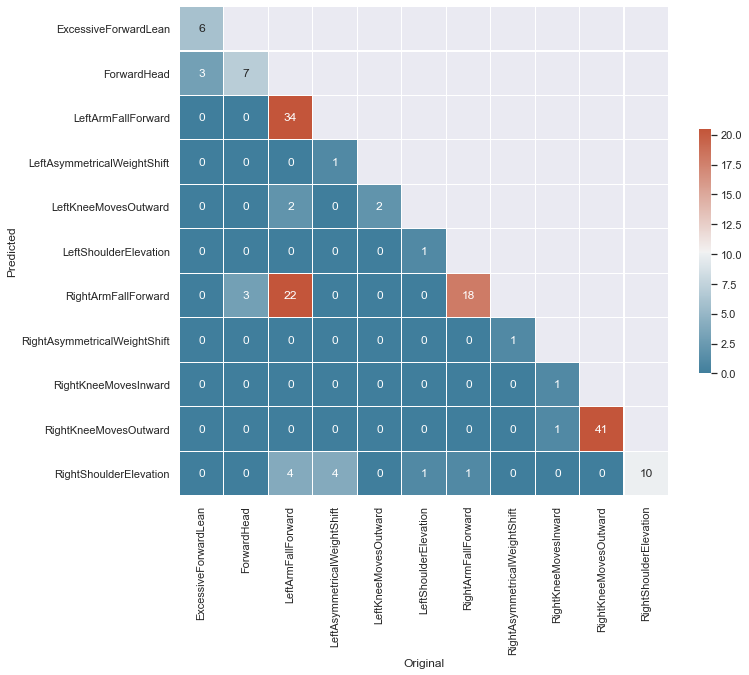

In [296]:
pivot = confusion_matrix.to_numpy().max()/2
heatMap(confusion_matrix,pivot,0)